# Image Classification using Pytorch


1. Reading the input image
 - Performing transformations on the image, for example resize, center crop, normalization, etc.
2. Forward Pass: Use the weights to predict the output. 
3. Based on the scores obtained, display the predictions.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
from torchvision import datasets, models, transforms
import torch
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from pytz import timezone
import copy
import time

Load Data
---------

we can initialize the data transforms, image datasets, and the dataloaders.

If you use models with the hard-coded normalization values, you should specify image transformations.

Torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.




In [3]:
print("Initializing Datasets and Dataloaders...")

batchSize = 8
inputSize = 32 # 299 for VGG, 32 for CNN 
transform = transforms.Compose([
        transforms.RandomResizedCrop(inputSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
Files already downloaded and verified
Files already downloaded and verified


Define a Convolution Neural Network
---------
Define the neural network that has some learnable parameters (or weights).
You can modify it.



In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Training Model
---------

The train_model function handles the training and validation of a given model. 

It takes a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate. 

we need to find out the index of maximum-score and use this index to find out the prediction.


In [5]:
from __future__ import print_function
from __future__ import division
import torch

import copy
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs):

    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = [0. for i in range(num_epochs)]
    test_losses = [0. for i in range(num_epochs)]

    train_accuracies = [0. for i in range(num_epochs)]
    test_accuracies = [0. for i in range(num_epochs)]

    label_acc_per_epoch = [[0] * num_epochs for i in range(10)]
    label_val_per_epoch = [[0] * num_epochs for i in range(10)]

    batch_loss = 0.0
    
    checkPoint = 2000;
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_loss = 0.0

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        class_correct_train = list(0. for i in range(10))
        class_total_train = list(0. for i in range(10))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for j, (inputs, labels) in enumerate(dataloaders[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                correct_train_iter, total_train_iter = 0.0, 0.0

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    batch_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    c = (preds == labels).squeeze()
                    total_train_iter += labels.size(0)  ##32
                    correct_train_iter += preds.eq(labels).sum().item()  ## 0~32

                    for i in range(len(labels)):
                        label = labels[i]
                        class_correct[label] += c[i].item()
                        class_total[label] += 1

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    if phase == 'train':
                        if j % checkPoint == checkPoint - 1 :
                            train_acc_iter = correct_train_iter / total_train_iter
                            train_loss_iter = batch_loss / checkPoint

                            print('\n[%d, %5d] loss: %.3f accuracy: %.3f' % (
                            epoch + 1, j + 1, train_loss_iter, train_acc_iter))

                            batch_loss = 0.0

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # print(dataloaders[phase].dataset)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                for i in range(10):
                    acc = class_correct[i] / class_total[i]
                    label_acc_per_epoch[i][epoch] = acc

                train_losses[epoch] = epoch_loss
                train_accuracies[epoch] = epoch_acc
            else:
                for i in range(10):
                    acc = class_correct[i] / class_total[i]
                    label_val_per_epoch[i][epoch] = acc

                test_losses[epoch] = epoch_loss
                test_accuracies[epoch] = epoch_acc

            print('{} Loss: {:.3f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    history = {
                "train_losses": train_losses,
                "train_accuracies": train_accuracies,
                "test_losses": train_losses,
                "test_accuracies": train_accuracies,
                "label_acc_per_epoch": label_acc_per_epoch,
                "label_val_per_epoch": label_val_per_epoch
              }

    return model, history

Run Training and Validation Step
---------

- Define the neural network 

- Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and Adam optimizer.

In [7]:
num_epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Initialize the non-pretrained version of the model used for this run
scratch_model = Net() ## non-pretrained model

## Inception v3 
#scratch_model = models.inception_v3(pretrained=True, aux_logits=False)

## VGG19
#scratch_model = models.vgg19(pretrained='true')
#scratch_model.classifier[6] = nn.Linear(4096, 10)

print(scratch_model)

scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(scratch_model.parameters(), lr=0.001)
scratch_criterion = nn.CrossEntropyLoss()

data_set = {'train': trainloader, 'val': testloader}
model, history = train_model(scratch_model, data_set, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/29
----------

[1,  2000] loss: 2.168 accuracy: 0.250

[1,  4000] loss: 1.962 accuracy: 0.000

[1,  6000] loss: 1.853 accuracy: 0.125
train Loss: 1.9871 Acc: 0.2591
val Loss: 1.8978 Acc: 0.3001

Epoch 1/29
----------

[2,  2000] loss: 3.207 accuracy: 0.500

[2,  4000] loss: 1.766 accuracy: 0.250

[2,  6000] loss: 1.732 accuracy: 0.625
train Loss: 1.7617 Acc: 0.3527
val Loss: 1.7275 Acc: 0.3653

Epoch 2/29
----------

[3,  2000] loss: 3.003 accuracy: 0.375

[3,  4000] loss: 1.696 accuracy: 0.250

[3,  6000] loss: 1.671 accuracy: 0.500
train Loss: 1.6892 Acc: 0.3831
val Loss: 1.6777 Acc: 0.388

Visualizing your network in PyTorch
---------

Let's plot the accuracy and loss 

No handles with labels found to put in legend.


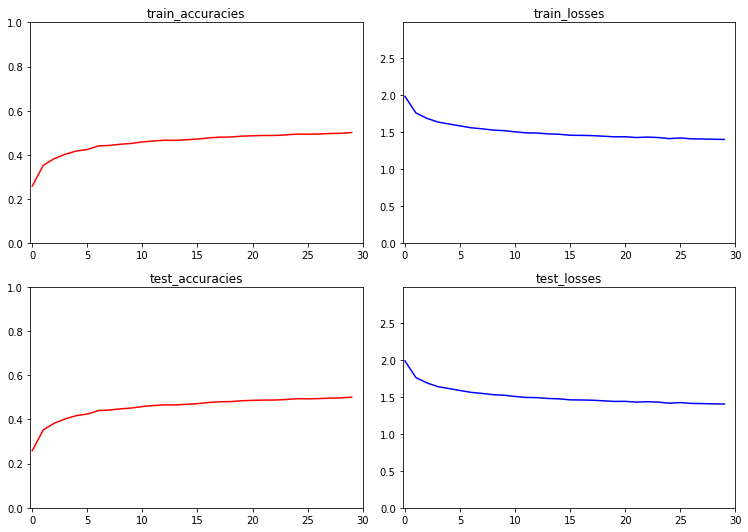

In [9]:
#fig = plt.figure()

fig = plt.figure()
fig.set_size_inches(10.5, 7.5)
plot_title = ["train_accuracies", "train_losses", "test_accuracies", "test_losses"]

for i in range(4):
    subplot = fig.add_subplot(2, 2, i+1)
    subplot.set_xlim([-0.2, num_epochs])
    subplot.set_ylim([0.0, 1 if i % 2 == 0 else max(history[plot_title[i]])+1])
    subplot.set_title(plot_title[i])
    subplot.plot(history[plot_title[i]], color = ("red" if i % 2 == 0 else "blue"))

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Plot train accuracy and validation accuracy for each epoch

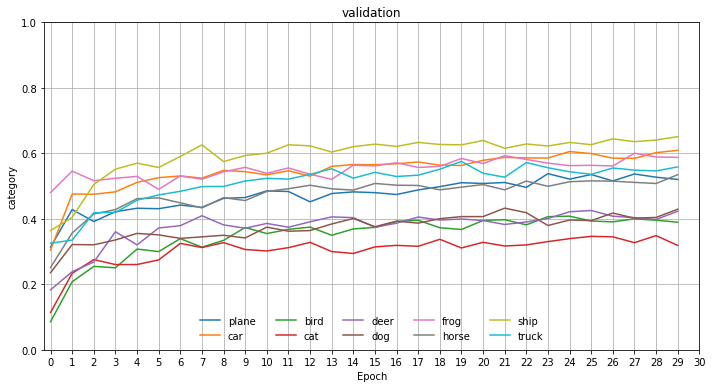

In [16]:
fig = plt.figure(1,)
fig.set_size_inches(10, 5.5)

for i in range(0, 10):
    a = plt.plot(history["label_val_per_epoch"][i], label='%s' % classes[i])

plt.title("validation")
plt.ylabel('category')
plt.xlabel('Epoch')
plt.grid(True)
plt.ylim((0,1))
plt.xlim((-0.3, num_epochs))
plt.xticks(np.arange(0, num_epochs+1, 1.0))
plt.tight_layout()
plt.legend(loc='lower center', ncol=5, frameon=False)

plt.show()

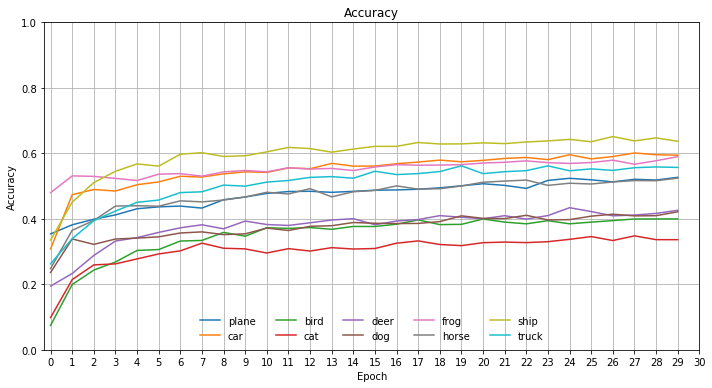

In [14]:
fig = plt.figure(1,)
fig.set_size_inches(10, 5.5)

for i in range(0, 10):
    a = plt.plot(history["label_acc_per_epoch"][i], label='%s' % classes[i])

plt.title("Accuracy")
plt.ylabel('category')
plt.xlabel('Epoch')
plt.grid(True)
plt.ylim((0,1))
plt.xlim((-0.3, num_epochs))
plt.xticks(np.arange(0, num_epochs+1, 1.0))
plt.tight_layout()
plt.legend(loc='lower center', ncol=5, frameon=False)

plt.show()
